In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!wget https://raw.githubusercontent.com/ed-donner/llm_engineering/refs/heads/main/week6/loaders.py

--2025-01-27 13:12:35--  https://raw.githubusercontent.com/ed-donner/llm_engineering/refs/heads/main/week6/loaders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2775 (2.7K) [text/plain]
Saving to: ‘loaders.py’

loaders.py          100%[===================>]   2.71K  --.-KB/s    in 0s      

2025-01-27 13:12:36 (42.4 MB/s) - ‘loaders.py’ saved [2775/2775]



In [3]:
!wget https://raw.githubusercontent.com/ed-donner/llm_engineering/refs/heads/main/week6/items.py

--2025-01-27 13:12:37--  https://raw.githubusercontent.com/ed-donner/llm_engineering/refs/heads/main/week6/items.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3658 (3.6K) [text/plain]
Saving to: ‘items.py’

items.py            100%[===================>]   3.57K  --.-KB/s    in 0s      

2025-01-27 13:12:37 (52.3 MB/s) - ‘items.py’ saved [3658/3658]



In [5]:
# pip installs
!pip install --upgrade pip
!pip install -q datasets requests torch peft  transformers trl accelerate sentencepiece wandb matplotlib 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [6]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("write")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
login(hf_token)

In [8]:
# imports

import os
import re
import math
import random
from tqdm import tqdm
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
import wandb
from peft import LoraConfig,PeftModel
import torch.nn.functional as F
from trl import SFTTrainer, SFTConfig
from datetime import datetime
import matplotlib.pyplot as plt
from items import Item
from loaders import ItemLoader
from collections import Counter, defaultdict

/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
E0000 00:00:1737983688.646963      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [13]:
# xm.set_runtime("lazy")  # Remove this line
print(met.metrics_report())
import torch_xla
import torch_xla.core.xla_model as xm

print(f"Available TPU device: {xm.xla_device()}")


Counter: RegisterXLAFunctions
  Value: 1

Available TPU device: xla:0


In [15]:
!pip install torch-xla -U
!pip install torch torchvision torchaudio -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 60.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch-xla
    Found existing installation: torch-xla 2.5.0+libtpu
    Uninstalling torch-xla-2.5.0+libtpu:
      Successfully uninstalled torch-xla-2.5.0+libtpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0
    Uninstalling torch-2.5.0:
      Successfully uninstalled torch-2.5.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0
    Uninstalling torchvision-0.20.0:
      Successfully uninstalled torchvision-0.20.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.0
    Uninstalling torchaudio-2.5.0:
      Successfully uninstalled torcha

In [16]:
import torch
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met

device = xm.xla_device()
print("TPU Device:", device)

# Force TPU execution
tensor = torch.randn(5, 5).to(device)
print("Tensor created on TPU:", tensor)

print(met.metrics_report())


TPU Device: xla:0
Tensor created on TPU: tensor([[-0.5085,  0.4757, -2.0845,  0.3967,  1.6722],
        [ 0.2681,  0.3504,  1.0312,  0.4093,  1.0900],
        [ 0.9713, -1.0979,  1.3825, -0.0521, -0.8882],
        [-0.3580,  1.3225, -0.3013, -0.2989,  0.9846],
        [ 0.3881, -0.6750,  1.2213, -1.8385,  0.1023]], device='xla:0')
Metric: IrValueTensorToXlaData
  TotalSamples: 1
  Accumulator: 551.581us
  Percentiles: 1%=551.581us; 5%=551.581us; 10%=551.581us; 20%=551.581us; 50%=551.581us; 80%=551.581us; 90%=551.581us; 95%=551.581us; 99%=551.581us
Metric: LazyTracing
  TotalSamples: 4
  Accumulator: 017ms243.660us
  ValueRate: 01s208ms355.871us / second
  Rate: 280.301 / second
  Percentiles: 1%=614.557us; 5%=614.557us; 10%=614.557us; 20%=614.557us; 50%=003ms985.131us; 80%=011ms358.298us; 90%=011ms358.298us; 95%=011ms358.298us; 99%=011ms358.298us
Metric: TensorToData
  TotalSamples: 1
  Accumulator: 478.725us
  Percentiles: 1%=478.725us; 5%=478.725us; 10%=478.725us; 20%=478.725us; 50%=

In [17]:
import os

os.environ["XRT_TPU_CONFIG"] = "local"
os.environ["TPU_NAME"] = "local"
os.environ["TPU_NUM_DEVICES"] = "8"


# Load Dataset 

In [18]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

Generating full split: 94327 examples [00:31, 3036.98 examples/s]


In [19]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [20]:
# Investigate a particular datapoint
datapoint = dataset[2]

In [21]:
# Investigate

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [22]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [23]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

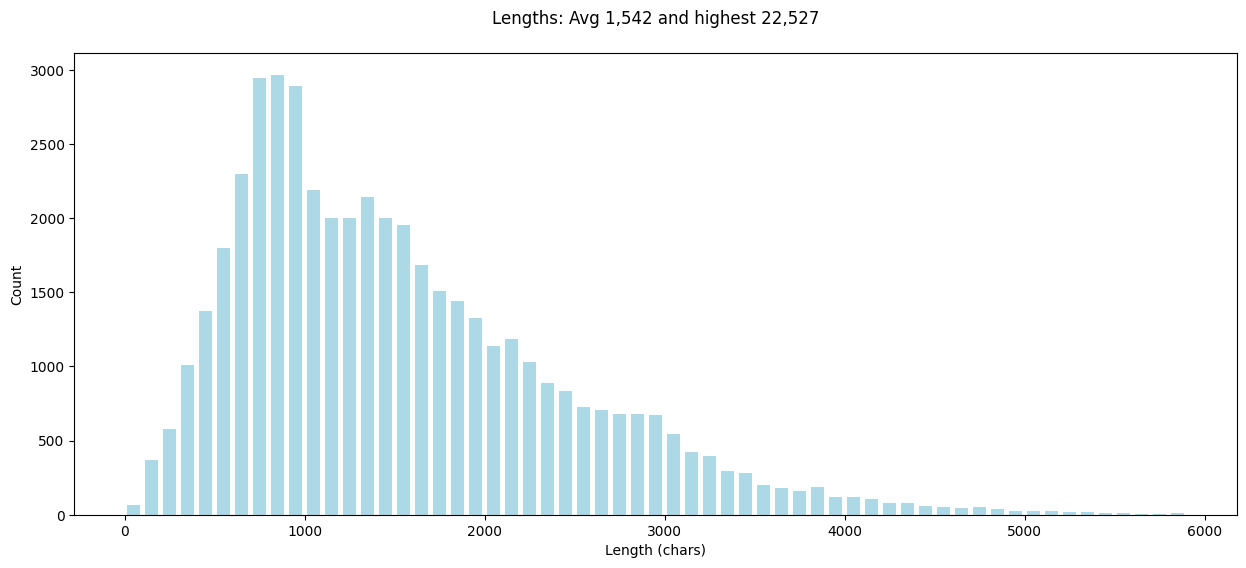

In [24]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

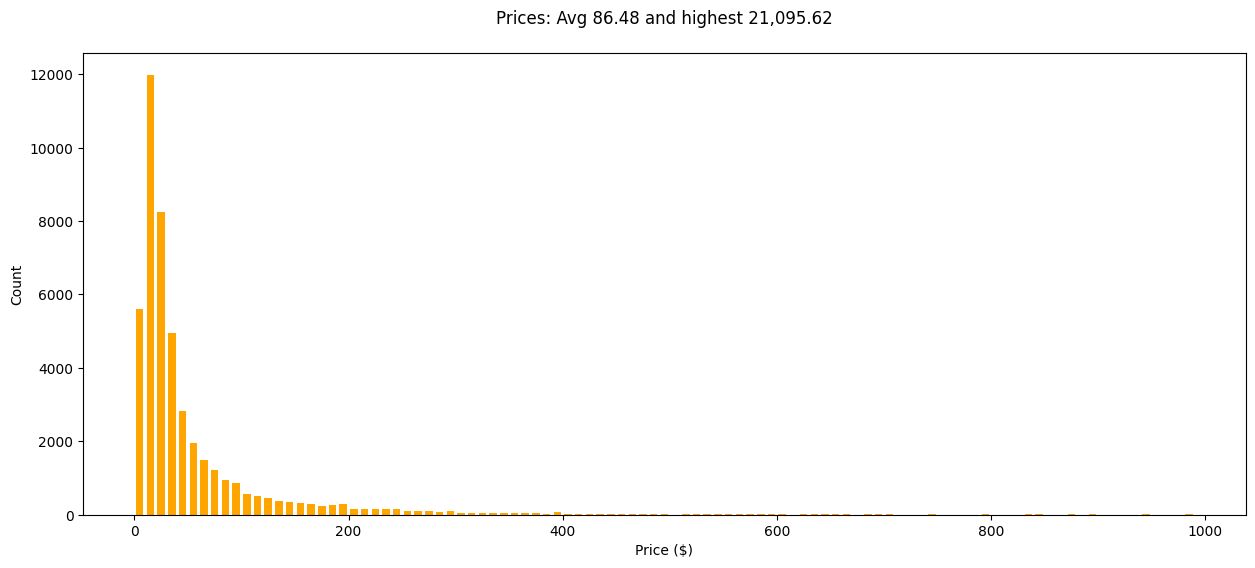

In [25]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [26]:
# So what is this item??

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


Now it's time to curate our dataset
We select items that cost between 1 and 999 USD

We will be create Item instances, which truncate the text to fit within 180 tokens using the right Tokenizer

And will create a prompt to be used during Training.

Items will be rejected if they don't have sufficient characters.

In [27]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [28]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [29]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


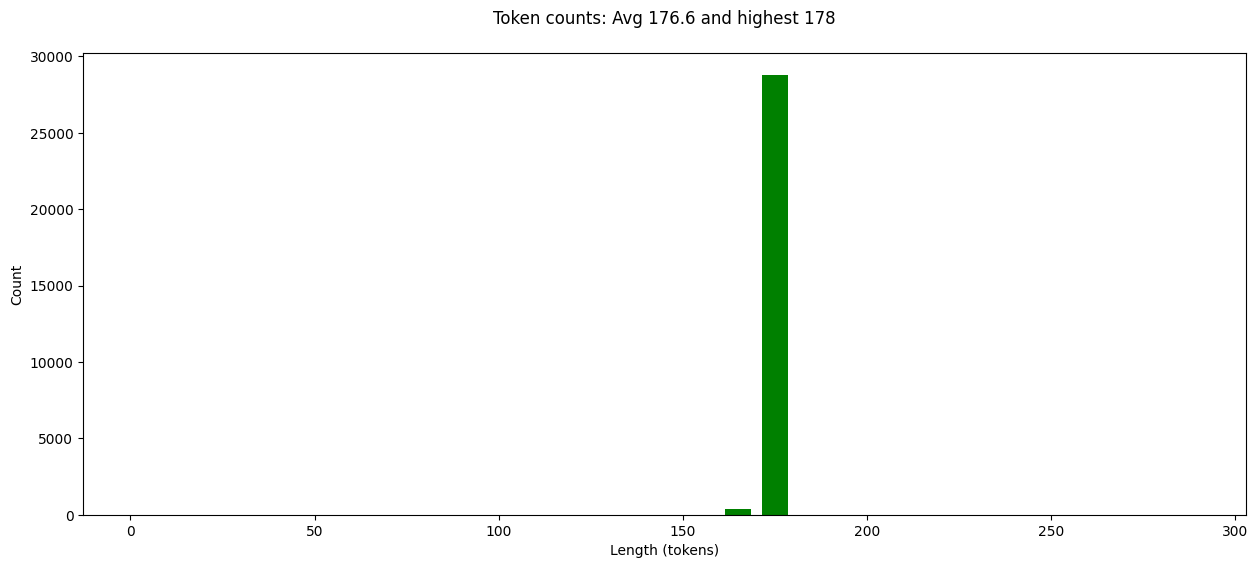

In [30]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

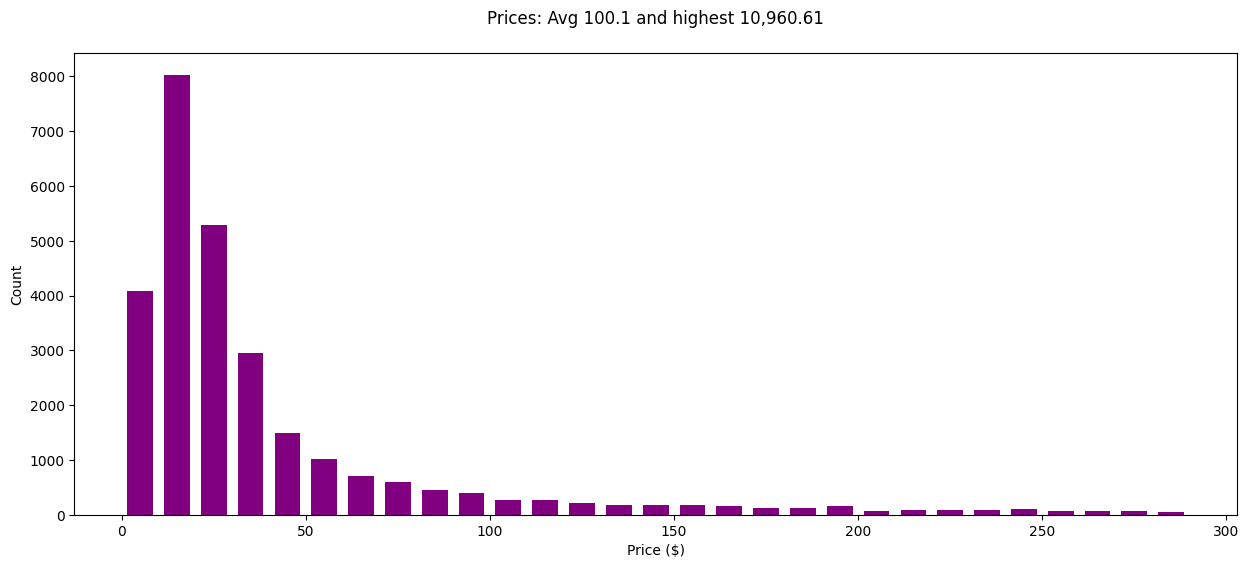

In [31]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

 look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [32]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]

In [33]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Completed Appliances with 28,625 datapoints in 0.2 mins


In [34]:
print(f"A grand total of {len(items):,} items")

A grand total of 28,625 items


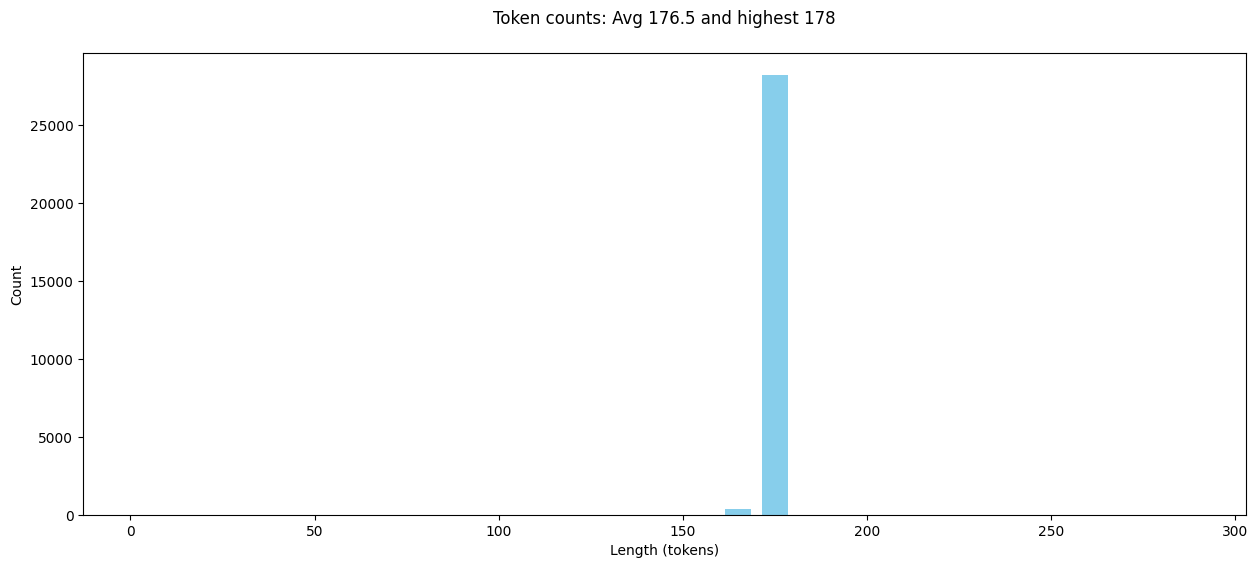

In [35]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

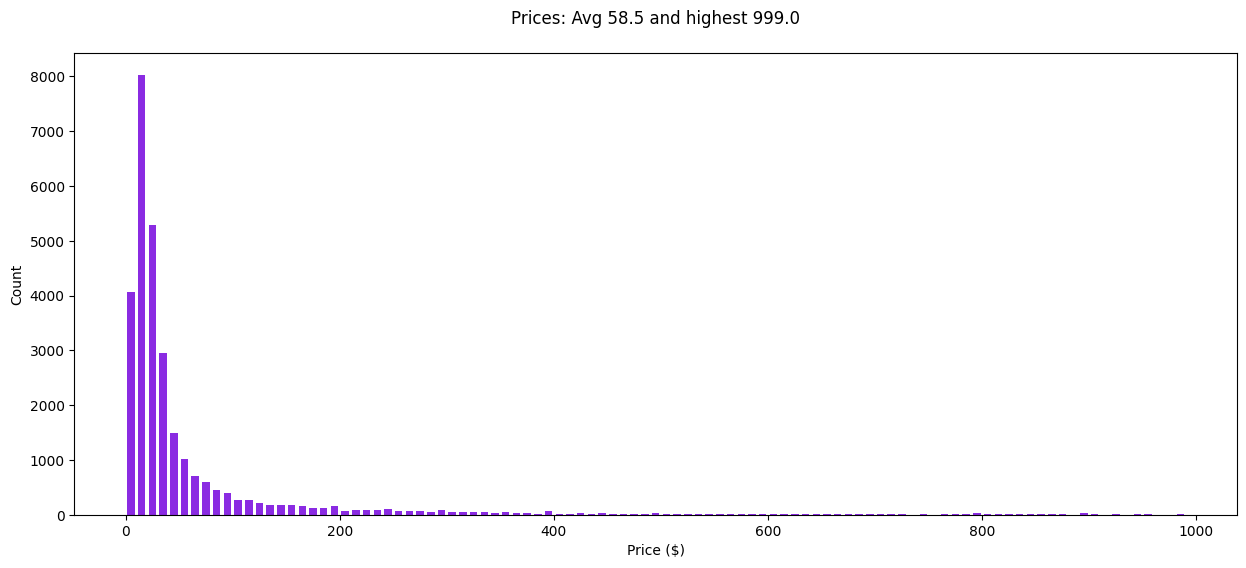

In [36]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

## Final checks

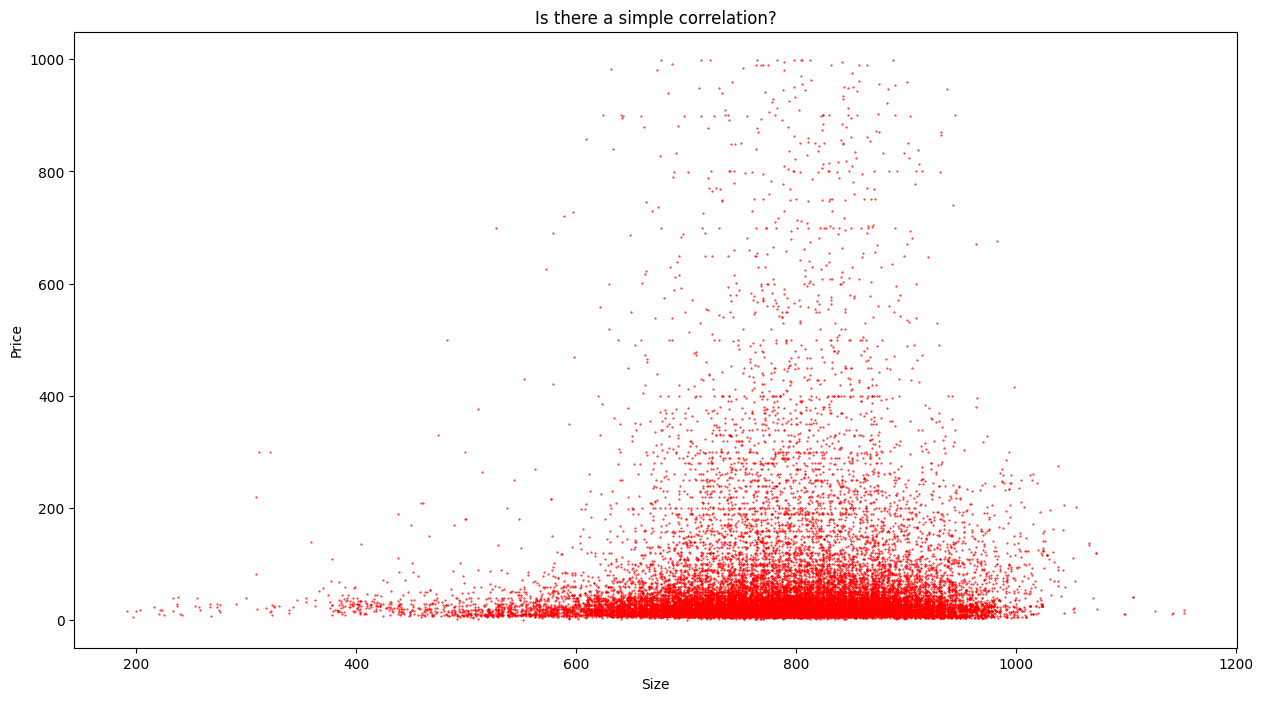

In [37]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [38]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [39]:
report(sample[500])

How much does this cost to the nearest dollar?

Milk Frothing Pitcher Jug - Stainless Steel Coffee Tools Cup - Suitable for Espresso, Latte Art and Frothing Milk, Attached Dessert Coffee Spoons
★PROFESSIONAL QUALITY★ Capacity of 12 oz (350 ml). This milk frothing cup made of Food-grade 18/8 stainless steel, resists odor retention, stain-proof, rust-proof, crash-proof and heat-resistant, solid and durable. Easy to clean & Dishwasher safe. ★ELEGANT DESIGN★ Mirror finish outside & Brush polish inside, Tapered dripless spout make it more outstanding and attractive,let it to be a good decor for your kitchen. 12 oz big capacity makes the milk pitcher perfect for single or 2 cup, size for the family, office or commercial,

Price is $8.00
[5274, 477, 8518, 3638, 7117, 374, 400, 23, 13, 410]
[' office', ' or', ' commercial', ',\n\n', 'Price', ' is', ' $', '8', '.', '00']


# Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, same goes  with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement

In [40]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


In [41]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [42]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


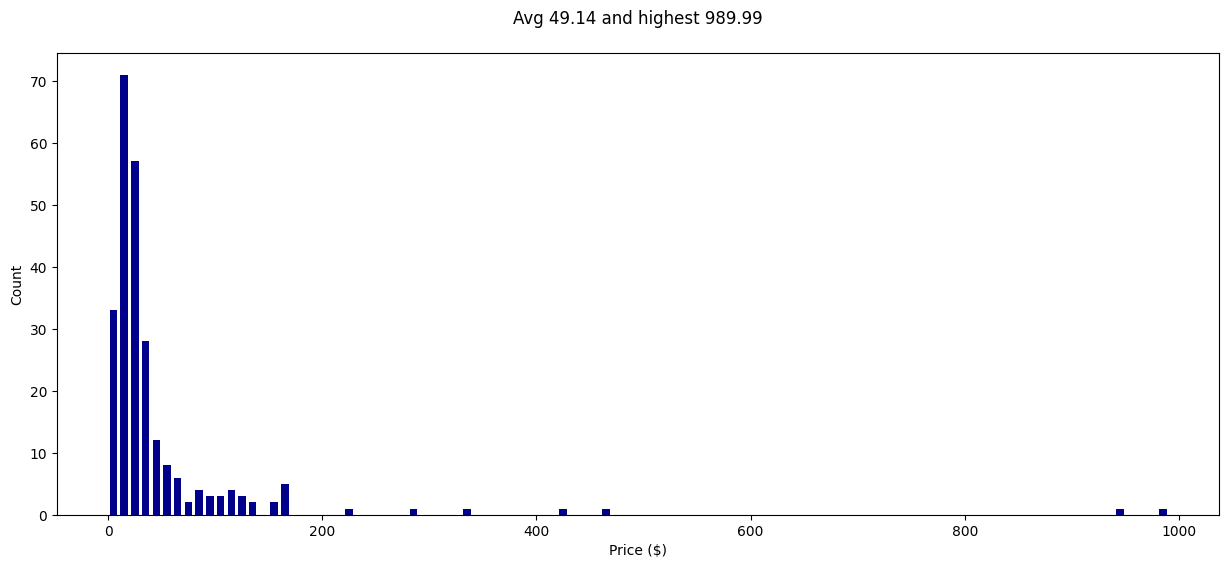

In [43]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [44]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [45]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

DATASET_NAME = "researcherrr/price-prediction-data"
dataset.push_to_hub(DATASET_NAME)

In [46]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
HF_USER = "researcherrr" 

# Data

DATASET_NAME = "researcherrr/pricer-data"
MAX_SEQUENCE_LENGTH = 182

# Run name for saving the model in the hub

RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# The run itself

RUN_NAME = "2025-01-27_11.51.44"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training

EPOCHS = 3
BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

# Admin config

STEPS = 50
SAVE_STEPS = 5000
LOG_TO_WANDB = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [47]:
train = dataset['train']
train

Dataset({
    features: ['text', 'price'],
    num_rows: 25000
})

In [48]:
test = dataset['test']
test

Dataset({
    features: ['text', 'price'],
    num_rows: 2000
})

In [49]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color\n\nPrice is $",
 'price': 65.99}

In [50]:
# Log in to Weights & Biases
wandb_api_key  = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=wandb_api_key)

wandb: Currently logged in as: amanagnihotri902 (amanagnihotri902-delhi-skill-and-entrepreneurship-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [51]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## Now load the Tokenizer and Model

# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [53]:
import torch_xla.core.xla_model as xm

In [54]:
import torch_xla.core.xla_model as xm
import torch

torch.cuda.empty_cache()
xm.mark_step()


In [55]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16,  # Use TPU-compatible dtype
    device_map="auto"  # Ensure model is placed on TPU
) 
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Memory footprint: 16060.5 MB


# Data Collator

It's important that we ensure during Training that we are not trying to train the model to predict the description of products; only their price.

We need to tell the trainer that everything up to "Price is $" is there to give context to the model to predict the next token, but does not need to be learned.

The trainer needs to teach the model to predict the token(s) after "Price is $".

There is a complicated way to do this by setting Masks, but luckily HuggingFace provides a super simple helper class to take care of this for us.

In [56]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

# AND NOW

## We set up the configuration for Training

We need to create 2 objects:

A LoraConfig object with our hyperparameters for LoRA

An SFTConfig with our overall Training parameters

In [57]:
import torch_xla.core.xla_model as xm

device = xm.xla_device()
base_model = base_model.to(device)

In [ ]:
# First, specify the configuration parameters for LoRA
import torch_xla.core.xla_model as xm
lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=8,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)
base_model.gradient_checkpointing_enable()
# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters

fine_tuning = SFTTrainer(
    model=base_model.to(xm.xla_device()),  # Move model to TPU
    train_dataset=train,
    peft_config=lora_parameters,
    processing_class=tokenizer,
    args=train_parameters,
    data_collator=collator
)

Map: 100%|██████████| 25000/25000 [00:03<00:00, 7852.24 examples/s]


In [ ]:
# Fine-tune!
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

In [ ]:
if LOG_TO_WANDB:
  wandb.finish()

# Infrence 

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

In [ ]:
fine_tuned_model

In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [ ]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

In [ ]:
Tester.test(improved_model_predict, test)